### Simulate images to match experimental data and calibrate PT area with diffusivity

In [2]:
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join('../step3_Deep-SnapTrack/')) # or the path to your source code
sys.path.insert(0, module_path)

from pathlib import Path
import tifffile as tiff
import csv
import numpy as np
import torch
from os import path
import pandas as pd
from tqdm import tqdm
from ptorch_CNN_model import Model as buildModel

class IndividualNormalize(object):
    def __init__(self,upsampling_factor):
        self.upsampling_factor = upsampling_factor

    def __call__(self, sample):
        img = np.array(sample)

        # Define a function that projects an image to the range [0,1]
        img = np.squeeze(img)
        min_val = img.min()
        max_val = img.max()
        img = (img - min_val) / (max_val - min_val)

        # Normalize image given mean and std
        mean_img = img.mean()
        std_img = img.std()
        img = (img - mean_img) / std_img

        # Upsampling using a simple nearest neighbor interp.
        img = np.kron(img, np.ones((1, self.upsampling_factor, self.upsampling_factor)))
        
        return img
    
def simple_mask_cutoff(pred_img, min_threshold=0.1):
    # rescale image so that in the range [0 1]
    rescale_pred_img = (pred_img-pred_img.min())/(pred_img.max()-pred_img.min())

    # Find the index where the cumulative distribution first exceeds 
    # use contrast (Max and Min)
    pixel_threshold_index = rescale_pred_img >= min_threshold

    mask = np.zeros(pred_img.shape)

    # Get the corresponding pixel value
    mask[pixel_threshold_index] = 1

    area = mask.sum()

    return mask, area

# Define CUDA device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
f'Using device {device}'

'Using device cuda'

### Estimate the diffusivity based on simulated images

In [ ]:
# Define the directory of model weight
weights_file = Path('/path/to/trained_models/your_trained_model_name.pth')
# Define the directory containing your images
parent_path = Path('/path/to/save/simulated_dataset_forCalibrate_DiffCoeff')
img_path = parent_path.joinpath('imgs')
info_path = parent_path.joinpath('annotations')
csv_savepath = parent_path.joinpath('your_trained_model_name_PT_area_results.csv')

# Define normalization transformation
transform_img_norm = IndividualNormalize(upsampling_factor=10)

# Build the model
model = buildModel().to(device)
model.eval()

# Load the trained weights
model.load_state_dict(torch.load(weights_file))
f'Model loaded from {weights_file}'

# Get a list of all files in the directory and sort them
img_files = list(img_path.glob('*.img.tif'))

csv_filename = path.join(csv_savepath)
with open(csv_filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write the header
    writer.writerow(['ImageName', 'frame', 'loc_id', 'simSPT_D', 'D_value', 'D_fromMSD', 'logD_fromMSD', 'exposure_time', 'molecule_class', 'x_pix_pos', 'y_pix_pos', 'SNR','background','noise','PT_area'])    

    for img_file in tqdm(img_files, total=len(img_files)):
        img = tiff.imread(img_file)
        info_file = info_path.joinpath( img_file.stem[:-4]+'.info.txt')
        info = pd.read_csv(info_file,sep='\t')
        total_frame_num = img.shape[0]
        for i in range(total_frame_num):
            img_norm = transform_img_norm(img[i])            
            # Convert the numpy array to a PyTorch tensor and move it to the CUDA device
            img_norm_tensor = torch.as_tensor(img_norm).float().unsqueeze(0).to(device)
            outputs = model(img_norm_tensor)

            outputs_cpu = outputs.cpu().detach().numpy()
            outputs_cpu = outputs_cpu.squeeze()

            # Threshold negative values
            outputs_cpu[outputs_cpu < 0] = 0
            mask, PT_area = simple_mask_cutoff(pred_img=outputs_cpu, min_threshold=0.1) # current best solution to estimate mobility                        

            writer.writerow([
                img_file.name,
                info.frame[i],
                info.loc_id[i],
                info.simSPT_D[i],
                info.D_value[i],
                info.D_fromMSD[i],
                info.logD_fromMSD[i],
                info.exposure_time[i],
                info.molecule_class[i],
                info.x_pix_pos[i],
                info.y_pix_pos[i],
                info.SNR[i],
                info.background[i],
                info.noise[i],
                PT_area
            ])                
        
print(f"CSV file '{csv_filename}' has been created.")


100%|██████████| 22/22 [00:17<00:00,  1.29it/s]

CSV file '/mnt/disk1/WZH-DataCenter/PROCESS-SPT/test_smldm/simulated_dataset_forCalibrate_DiffCoeff/your_trained_model_name_PT_area_results.csv' has been created.


### Fitting on matlab curvefit app to obtain the constant
After obtain your_trained_model_name_PT_area_results.csv, fit using the equation y = a*sqrt(x), where y is PT area, and x is D_value, and obtain the fitting constant, which is the value of a.

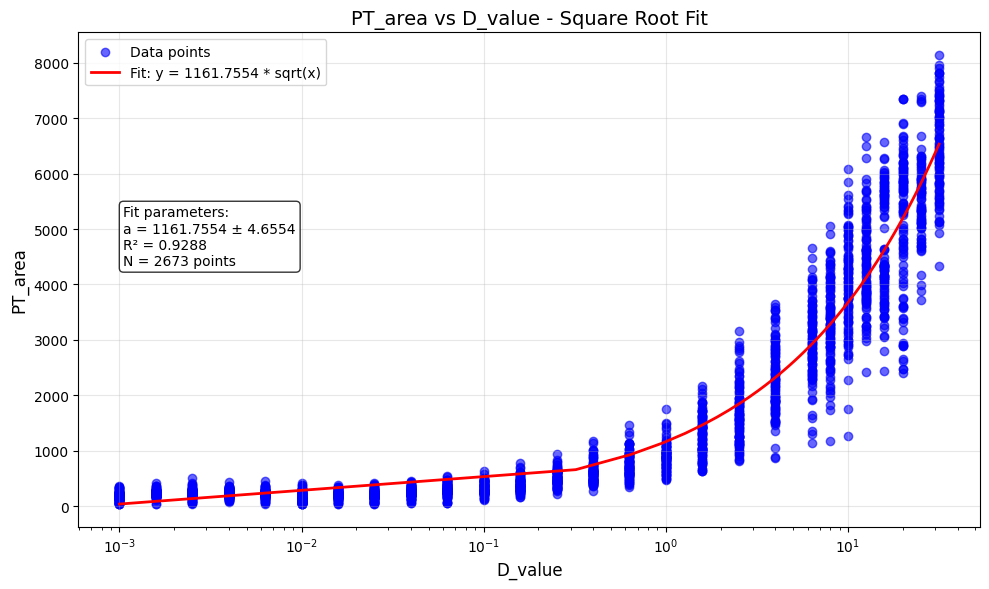

Fitting Results:
Fitted parameter a = 1161.7554 ± 4.6554
R-squared = 0.9288
Number of data points used = 2673

Data Statistics:
PT_area range: 31.0000 to 8145.0000
D_value range: 0.0010 to 31.6228
Correlation coefficient: 0.9232


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import os

# Read the CSV file
# csv_filename = '/dataB/dell_process_backup/To20230604/WZH-DataCenter/PROCESS-SPT/2023/simPSF_results/DeepSTORMDataset/20240321_debug2_shotnoise/MBX_20231220_110nmPix_rep2_epoch9_r1p41short_SRArea.csv'
csv_filename = "/path/to/save/simulated_dataset_forCalibrate_DiffCoeff/your_trained_model_name_PT_area_results.csv"  # Replace with your actual file path
df = pd.read_csv(csv_filename)

# Data preprocessing - remove rows with NaN or invalid values
df_clean = df.dropna(subset=['PT_area', 'D_value'])
df_clean = df_clean[(df_clean['PT_area'] > 0) & (df_clean['D_value'] > 0)]

# Define the fitting function: y = a * sqrt(x)
def sqrt_model(x, a):
    return a * np.sqrt(x)

# Prepare data for fitting
x_data = df_clean['D_value'].values
y_data = df_clean['PT_area'].values

# Perform the curve fitting
try:
    # Provide initial guess for parameter 'a'
    initial_guess = [1.0]  # You can adjust this based on your data scale
    
    # Perform the fit with bounds to avoid negative parameters
    popt, pcov = curve_fit(sqrt_model, x_data, y_data, p0=initial_guess, bounds=(0, np.inf))
    
    # Extract the fitted parameter
    a_fit = popt[0]
    a_error = np.sqrt(pcov[0][0])  # Standard error of the parameter
    
    # Calculate R-squared value
    y_pred = sqrt_model(x_data, a_fit)
    ss_res = np.sum((y_data - y_pred) ** 2)
    ss_tot = np.sum((y_data - np.mean(y_data)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)
    
    # Create fitted curve for plotting
    x_fit = np.linspace(x_data.min(), x_data.max(), 100)
    y_fit = sqrt_model(x_fit, a_fit)
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    
    # Plot original data
    plt.scatter(x_data, y_data, alpha=0.6, label='Data points', color='blue')
    
    # Plot fitted curve
    plt.plot(x_fit, y_fit, 'r-', linewidth=2, label=f'Fit: y = {a_fit:.4f} * sqrt(x)')
    
    # Customize the plot
    plt.xlabel('D_value', fontsize=12)
    plt.ylabel('PT_area', fontsize=12)
    plt.xscale('log')
    plt.title('PT_area vs D_value - Square Root Fit', fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # Add statistics text box
    stats_text = f'Fit parameters:\na = {a_fit:.4f} ± {a_error:.4f}\nR² = {r_squared:.4f}\nN = {len(x_data)} points'
    plt.annotate(stats_text, xy=(0.05, 0.65), xycoords='axes fraction', 
                bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8),
                fontsize=10, ha='left', va='top')
        
    plt.tight_layout()
    plt.show()
    
    # Print fitting results
    print("Fitting Results:")
    print(f"Fitted parameter a = {a_fit:.4f} ± {a_error:.4f}")
    print(f"R-squared = {r_squared:.4f}")
    print(f"Number of data points used = {len(x_data)}")
    
except Exception as e:
    print(f"Fitting failed: {e}")
    print("This might be due to insufficient data points or numerical issues.")

# Optional: Display basic statistics about the data
print("\nData Statistics:")
print(f"PT_area range: {df_clean['PT_area'].min():.4f} to {df_clean['PT_area'].max():.4f}")
print(f"D_value range: {df_clean['D_value'].min():.4f} to {df_clean['D_value'].max():.4f}")
print(f"Correlation coefficient: {df_clean['PT_area'].corr(df_clean['D_value']):.4f}")
